# Simple FEM for an elastic plate with a hole

## Create a mesh for the plate with hole

First we need to build the geometry. The shape and mesh is generated with pygmsh, exported to a vtk file that can be visualized with ParaView, and then imported for use in scikit-fem. 

<skfem MeshTri1 object>
  Number of elements: 2128
  Number of vertices: 1125
  Number of nodes: 1125
  Named boundaries [# facets]: right [30], left [30]


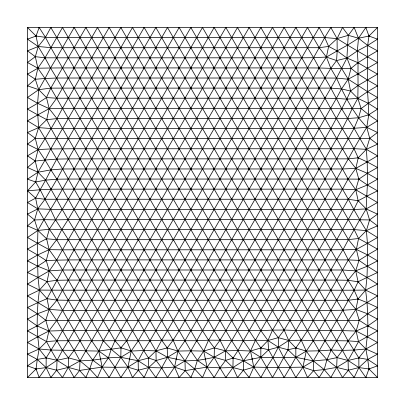

In [22]:
import pygmsh
import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import draw, plot

from global_constants import EPS0, LBD, MU, B0, X0, Y0, L, R

# Element size
N = 30
s = L / N

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = s
    rectangle = geom.add_rectangle([0.0, 0.0, 0.0], a=L, b=L)
    # hole = geom.add_disk([X0, Y0, 0.0], R)
    # geom.boolean_difference(rectangle, hole)
    m = geom.generate_mesh()
    m.write("mesh.vtk")

# Convert to scikit-fem mesh
mesh = fem.MeshTet().load("mesh.vtk")

# Label boundaries
mesh = mesh.with_boundaries(
    {
        "right": lambda x: x[0] == L,
        "left": lambda x: x[0] == 0,
    }
)

# Visualize the mesh
draw(mesh, figsize=(5, 5))
print(mesh)

## Create the FEM function space

In [23]:
# Define first order triangles and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementTriP1(), 2)
# Function space
basis = fem.Basis(mesh, element)

## Material model

A single 2D ply stiffness tensor is given as 

$$
\sigma = 2\mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u)I
$$

In [24]:
def sigma(eps):
    return  2.0 * MU * eps + LBD * eye(trace(eps), 2)

## Bilinear form of the weak form

$$ \int_\Omega \sigma \left [\nabla^s u \right] \cdot \nabla^s v dV = \int_\Omega f \cdot v dV $$

In [25]:
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@fem.LinearForm
def b(v, w):
    f = np.zeros(v.shape)
    f[0, :, :] = B0
    return dot(f, v)

## Boundary conditions

Left: 

$$ u_1 = 0, u_2 = 0$$

Right: 

$$ u_1 = \varepsilon_0 L, u_2 =0$$

In [26]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
u[basis.get_dofs({"right"}).nodal['u^1']] = EPS0*L

# Get remaining degrees of freedom
I = basis.complement_dofs(basis.get_dofs({"left", "right"}))

## Assemble and solve

In [27]:
# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

## Postprocessing

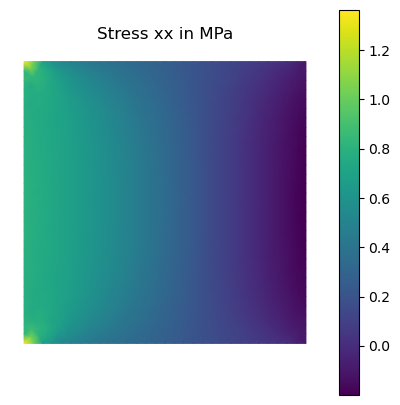

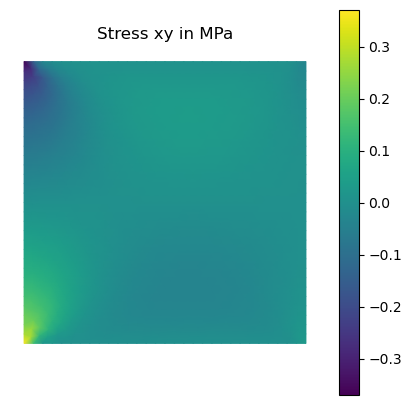

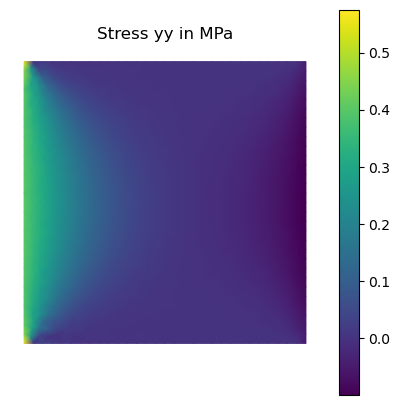

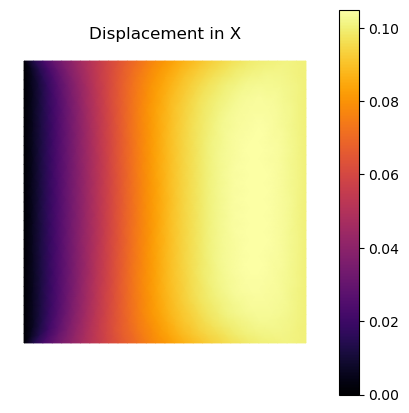

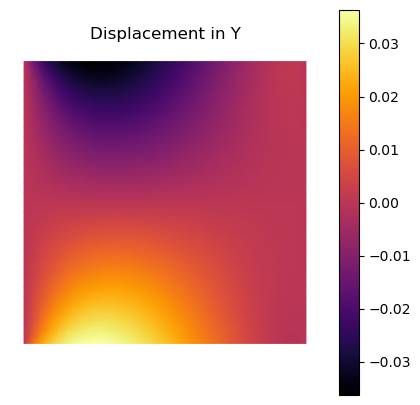

In [28]:
# Compute stress
sgb = basis.with_element(fem.ElementVector(element))
ui = basis.interpolate(u)
s = sgb.project(sigma(sym_grad(ui)))


# Plot results
p = plot(mesh, s[sgb.nodal_dofs[0]], shading='gouraud', colorbar=True, cmap="viridis", figsize=(5,5))
p.set_title("Stress xx in MPa");
p = plot(mesh, s[sgb.nodal_dofs[1]], shading='gouraud', colorbar=True, cmap="viridis", figsize=(5,5))
p.set_title("Stress xy in MPa");
p = plot(mesh, s[sgb.nodal_dofs[3]], shading='gouraud', colorbar=True, cmap="viridis", figsize=(5,5))
p.set_title("Stress yy in MPa");
p = plot(mesh, u[basis.nodal_dofs[0]], shading='gouraud', colorbar=True, cmap="inferno", figsize=(5,5))
p.set_title("Displacement in X");
p = plot(mesh, u[basis.nodal_dofs[1]], shading='gouraud', colorbar=True, cmap="inferno", figsize=(5,5))
p.set_title("Displacement in Y");